In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from path import Path
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier


In [2]:
# path to dataset
file_path = Path("/Users/Emily/downloads/cleaned_airbnb_dataset2.csv")
airbnb_df = pd.read_csv(file_path, index_col=0)
airbnb_df.head()

,host_id,host_is_superhost,property_type,room_type,neighborhood,accommodates,bedrooms,bathrooms,latitude,longitude,reviews,price,cleaning_fee,total
room_id,,,,,,,,,,,,,,
958,1169,t,Apartment,Entire home/apt,Western Addition,3,1.0,1.0,37.76931,-122.43386,217,170.0,100.0,270.0
3850,4921,t,House,Private room,Inner Sunset,2,1.0,1.0,37.75402,-122.45805,160,99.0,10.0,109.0
5858,8904,f,Apartment,Entire home/apt,Bernal Heights,5,2.0,1.0,37.74511,-122.42102,111,235.0,100.0,335.0
7918,21994,t,Apartment,Private room,Haight Ashbury,2,1.0,4.0,37.76669,-122.45250,18,65.0,50.0,115.0
8142,21994,t,Apartment,Private room,Haight Ashbury,2,1.0,4.0,37.76487,-122.45183,8,65.0,50.0,115.0


In [13]:
airbnb2_df = airbnb_df.drop(['price','cleaning_fee','host_id'], axis=1)

In [14]:
airbnb2_df.head()

,host_is_superhost,property_type,room_type,neighborhood,accommodates,bedrooms,bathrooms,latitude,longitude,reviews,total
room_id,,,,,,,,,,,
958,t,Apartment,Entire home/apt,Western Addition,3,1.0,1.0,37.76931,-122.43386,217,270.0
3850,t,House,Private room,Inner Sunset,2,1.0,1.0,37.75402,-122.45805,160,109.0
5858,f,Apartment,Entire home/apt,Bernal Heights,5,2.0,1.0,37.74511,-122.42102,111,335.0
7918,t,Apartment,Private room,Haight Ashbury,2,1.0,4.0,37.76669,-122.45250,18,115.0
8142,t,Apartment,Private room,Haight Ashbury,2,1.0,4.0,37.76487,-122.45183,8,115.0


In [15]:
# defining features to begin prediction
features = ['host_is_superhost','property_type','room_type','neighborhood','accommodates','bedrooms',
           'bathrooms','latitude','longitude','reviews','total']

In [16]:
# filling missing values
num_cols = airbnb2_df.select_dtypes(exclude='object').columns
cat_cols = airbnb2_df.select_dtypes(include='object').columns
airbnb2_df[cat_cols] = airbnb2_df[cat_cols].apply(
    lambda col: col.fillna(col.mode()[0]))
airbnb2_df[num_cols] = airbnb2_df[num_cols].apply(
    lambda col: col.fillna(col.median()))

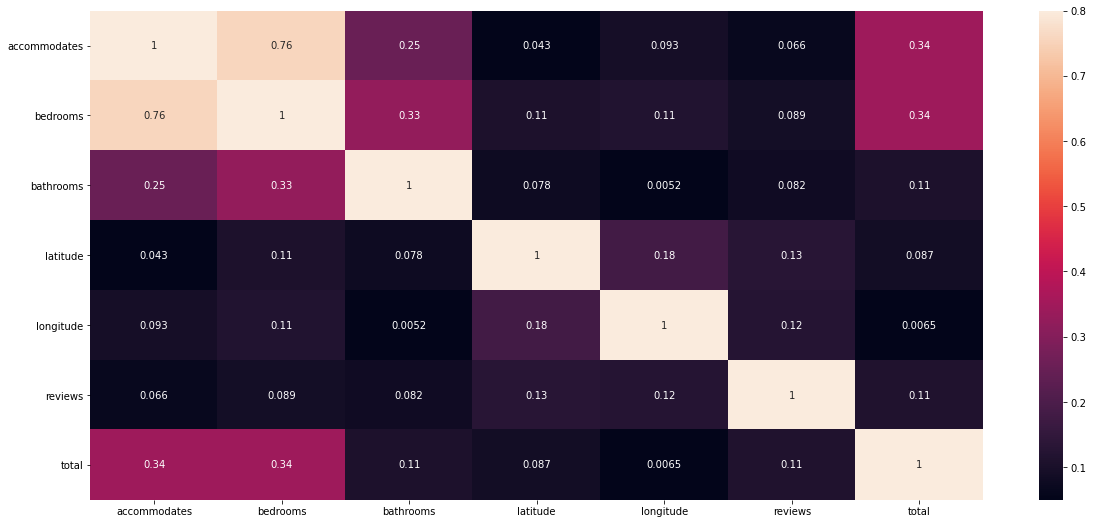

In [17]:
# heatmap
#try on original listings.csv
cmx = airbnb2_df.corr()
cmx = abs(cmx)
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(cmx, vmax=0.8, vmin=0.05, annot=True)

In [18]:
# higher number means higher weight in predicting total
cmx['total'].sort_values(ascending=False)

total           1.000000
accommodates    0.344671
bedrooms        0.344304
reviews         0.114434
bathrooms       0.108024
latitude        0.086590
longitude       0.006504
Name: total, dtype: float64

In [19]:
def train_and_test(df, model, test_size=0.2):
    target = airbnb2_df['total']
    features = airbnb2_df.copy().drop('total', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test) 
    print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))
    pred = np.round(np.exp(y_pred) + 1, 1)
    actual = np.round(np.exp(y_test) + 1, 1)
    plt.scatter(actual.to_numpy(), pred)
    plt.title('Predicted vs. Actual Price', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Listing Price')
    plt.ylabel('Predicted Listing Price')
    plt.show()

    return model

In [20]:
le = LabelEncoder()
airbnb2_df['property_type'] = le.fit_transform(airbnb2_df['property_type'])
airbnb2_df['room_type'] = le.fit_transform(airbnb2_df['room_type'])
airbnb2_df['neighborhood'] = le.fit_transform(airbnb2_df['neighborhood'])
airbnb2_df['host_is_superhost'] = le.fit_transform(airbnb2_df['host_is_superhost'])

R^2 test: -0.001


/Users/Emily/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/Users/Emily/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/Users/Emily/opt/anaconda3/envs/pythondata/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


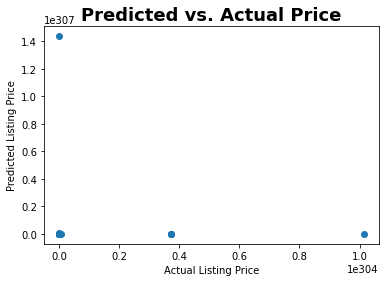

In [21]:
model = LGBMRegressor()
trained_model = train_and_test(airbnb2_df, model)

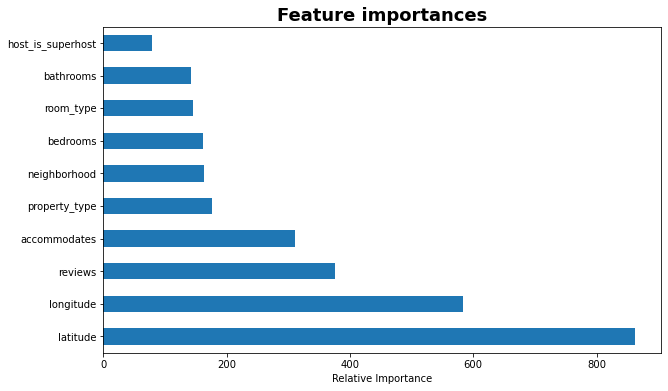

In [22]:
feat_imp = pd.Series(trained_model.feature_importances_,
                     index=airbnb2_df.columns.drop('total'))
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('Relative Importance')
plt.title("Feature importances", fontsize=18, fontweight='bold')
plt.show()

In [24]:
linreg = LinearRegression()

NameError: name 'LinearRegression' is not defined